***IMPORTS***

In [1]:
import subprocess

# Installation on Google Colab
try:
    import google.colab
    subprocess.run(['python', '-m', 'pip', 'install', 'skorch'])
except ImportError:
    pass

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from skorch import NeuralNetClassifier

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline,FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from skorch.callbacks import ProgressBar

import torch
import torch.cuda
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [3]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
import pandas as pd
import numpy as np
import csv
import re
import string
from collections import defaultdict

***LOADING THE DATASET***

In [5]:
# download dataset
!gdown 1QP6YuwdKFNUPpvhOaAcvv2Pcp4JMbIRs # x_train
!gdown 1QVo7PZAdiZKzifK8kwhEr_umosiDCUx6 # x_test
!gdown 1QbBeKcmG2ZyAEFB3AKGTgSWQ1YEMn2jl # y_train
!gdown 1QaZj6bI7_78ymnN8IpSk4gVvg-C9fA6X # y_test

Downloading...
From: https://drive.google.com/uc?id=1QP6YuwdKFNUPpvhOaAcvv2Pcp4JMbIRs
To: /content/x_train.txt
100% 64.1M/64.1M [00:00<00:00, 69.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1QVo7PZAdiZKzifK8kwhEr_umosiDCUx6
To: /content/x_test.txt
100% 65.2M/65.2M [00:00<00:00, 110MB/s]
Downloading...
From: https://drive.google.com/uc?id=1QbBeKcmG2ZyAEFB3AKGTgSWQ1YEMn2jl
To: /content/y_train.txt
100% 480k/480k [00:00<00:00, 48.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1QaZj6bI7_78ymnN8IpSk4gVvg-C9fA6X
To: /content/y_test.txt
100% 480k/480k [00:00<00:00, 104MB/s]


In [6]:
with open(f'x_train.txt') as f:
    x_train = f.read().splitlines()
with open(f'y_train.txt') as f:
    y_train = f.read().splitlines()
with open(f'x_test.txt') as f:
    x_test = f.read().splitlines()
with open(f'y_test.txt') as f:
    y_test = f.read().splitlines()

In [7]:
# combine x_train and y_train into one dataframe
train_df = pd.DataFrame({'text': x_train, 'label': y_train})

# comibne x_test and y_test into one dataframe
test_df = pd.DataFrame({'text': x_test, 'label': y_test})

***EXPLORATORY DATA ANALYSIS (EDA)***

In [8]:
train_df.head()

,text,label
0,Klement Gottwaldi surnukeha palsameeriti ning ...,est
1,"Sebes, Joseph; Pereira Thomas (1961) (på eng)....",swe
2,भारतीय स्वातन्त्र्य आन्दोलन राष्ट्रीय एवम क्षे...,mai
3,"Après lo cort periòde d'establiment a Basilèa,...",oci
4,ถนนเจริญกรุง (อักษรโรมัน: Thanon Charoen Krung...,tha


In [9]:
# Number of samples per language
print(train_df['label'].value_counts())

est    500
eng    500
vep    500
sgs    500
uig    500
      ... 
lmo    500
mya    500
ilo    500
csb    500
ltz    500
Name: label, Length: 235, dtype: int64


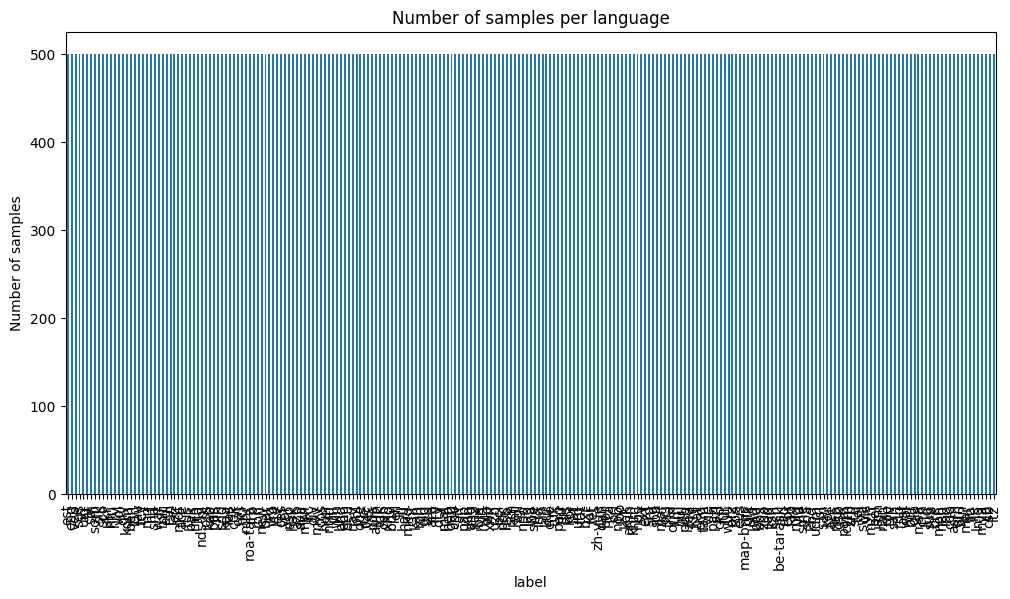

In [10]:
# Bar chart showing the number of samples per language

plt.figure(figsize=(12, 6))
train_df['label'].value_counts().plot(kind='bar')
plt.title('Number of samples per language')
plt.ylabel('Number of samples')
plt.xlabel('label')
plt.show()

In [11]:
# T: How many instances per label are there in the training and test set?
# Do you think this is a balanced dataset?
# Do you think the train/test split is appropriate?
# If not, please rearrange the data in a more appropriate way.

# Count instances per label in the training set
unique_labels_train, counts_train = np.unique(y_train, return_counts=True)
instances_per_label_train = dict(zip(unique_labels_train, counts_train))
print("Instances per label in the training set:", instances_per_label_train)

# Count instances per label in the test set
unique_labels_test, counts_test = np.unique(y_test, return_counts=True)
instances_per_label_test = dict(zip(unique_labels_test, counts_test))
print("Instances per label in the test set:", instances_per_label_test)

# Dataset is balanced
# There are 500 instances per label in both sets

# train and test set are split 50/50
print(len(x_train))
print(len(x_test))

Instances per label in the training set: {'ace': 500, 'afr': 500, 'als': 500, 'amh': 500, 'ang': 500, 'ara': 500, 'arg': 500, 'arz': 500, 'asm': 500, 'ast': 500, 'ava': 500, 'aym': 500, 'azb': 500, 'aze': 500, 'bak': 500, 'bar': 500, 'bcl': 500, 'be-tarask': 500, 'bel': 500, 'ben': 500, 'bho': 500, 'bjn': 500, 'bod': 500, 'bos': 500, 'bpy': 500, 'bre': 500, 'bul': 500, 'bxr': 500, 'cat': 500, 'cbk': 500, 'cdo': 500, 'ceb': 500, 'ces': 500, 'che': 500, 'chr': 500, 'chv': 500, 'ckb': 500, 'cor': 500, 'cos': 500, 'crh': 500, 'csb': 500, 'cym': 500, 'dan': 500, 'deu': 500, 'diq': 500, 'div': 500, 'dsb': 500, 'dty': 500, 'egl': 500, 'ell': 500, 'eng': 500, 'epo': 500, 'est': 500, 'eus': 500, 'ext': 500, 'fao': 500, 'fas': 500, 'fin': 500, 'fra': 500, 'frp': 500, 'fry': 500, 'fur': 500, 'gag': 500, 'gla': 500, 'gle': 500, 'glg': 500, 'glk': 500, 'glv': 500, 'grn': 500, 'guj': 500, 'hak': 500, 'hat': 500, 'hau': 500, 'hbs': 500, 'heb': 500, 'hif': 500, 'hin': 500, 'hrv': 500, 'hsb': 500, 'hun

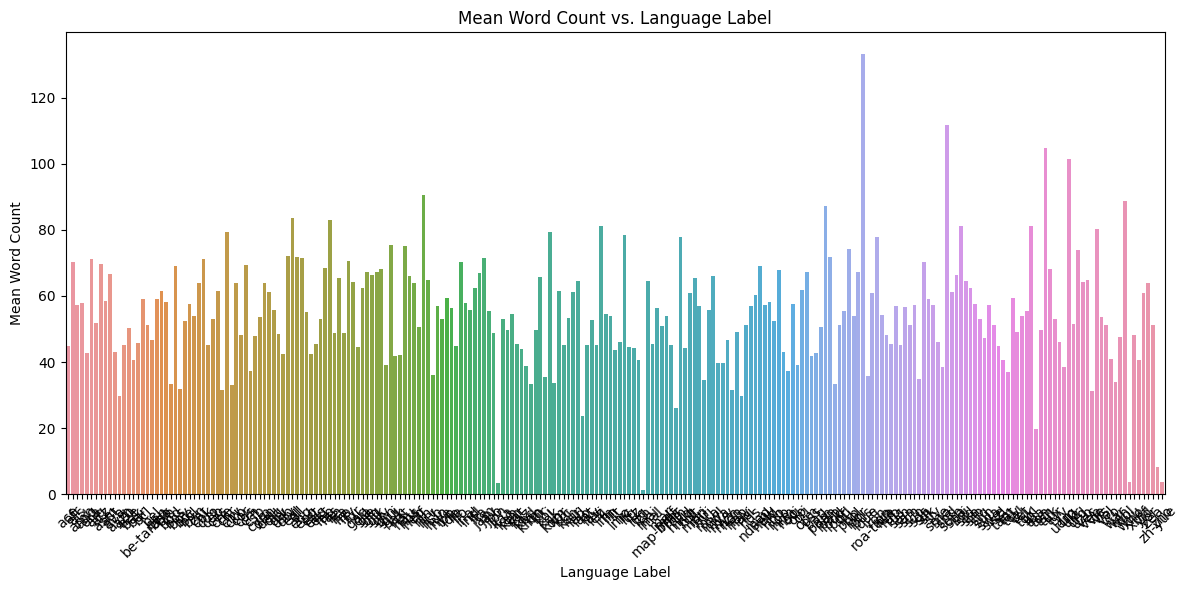

In [12]:
train_df['word_count'] = train_df['text'].apply(lambda x: len(x.split()))
mean_word_counts = train_df.groupby('label')['word_count'].mean().reset_index()

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(x='label', y='word_count', data=mean_word_counts)
plt.title('Mean Word Count vs. Language Label')
plt.ylabel('Mean Word Count')
plt.xlabel('Language Label')
plt.xticks(rotation=45)  # Rotates x-axis labels for better visibility if they are long
plt.tight_layout()
plt.show()

***DATA PREPROCESSING***

In [13]:
# The function aims to clean the text data by converting it to lowercase, removing punctuation marks, excess whitespaces and removing numbers.

def preprocess_text(text):
  # Convert all words to lower case
  text = text.lower()
  # Remove all punctuations
  text = text.translate(str.maketrans('', '', string.punctuation))
  # Remove numbers
  text = re.sub(r'\d+', '', text)
  text = ' '.join(text.split())
  return text

In [14]:
# T: Please use again the train/test data that includes English, German, Dutch, Danish, Swedish and Norwegian, plus 20 additional languages of your choice (the labels can be found in the file labels.csv)
# and adjust the train/test split if needed

# merge test and train dataset in order to rearange it later
frames = [train_df, test_df]
df_combined = pd.concat(frames)


selected_languages = ['eng', 'deu', 'nld', 'dan', 'swe', 'nob', 'est', 'oci', 'zea', 'pnb', 'wuu', 'pan', 'fur','ton', 'glk', 'bod', 'jpn', 'srd', 'ext', 'sin', 'che', 'pag', 'als', 'koi', 'kir', 'bul']
filtered_df = df_combined[df_combined['label'].isin(selected_languages)]

# Define the function to compute average word length
def average_word_length(text):
    words = text.split()
    if len(words) == 0:  # To handle potential empty strings
        return 0
    return sum(len(word) for word in words) / len(words)

# Create a new column 'avg_word_length'. We wanted to add this as a feature for our classification models.
filtered_df['avg_word_length'] = filtered_df['text'].apply(average_word_length)

# Apply the preprocess_text() function to the 'text' column
filtered_df['text'] = filtered_df['text'].apply(preprocess_text)

# Display the updated DataFrame
print(filtered_df.head())

<ipython-input-14-574fad0afb6e>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['avg_word_length'] = filtered_df['text'].apply(average_word_length)


                                                text label  word_count  \
0  klement gottwaldi surnukeha palsameeriti ning ...   est        46.0   
1  sebes joseph pereira thomas på eng the jesuits...   swe        32.0   
3  après lo cort periòde destabliment a basilèa t...   oci       160.0   
8  براعظم ایشیاء تے یورپ اتے پھیلے ہوئے دیس ترکی ...   pnb        45.0   
9  vanwehe zen gentsen ofkomst wor t een ok wè ga...   zea        52.0   

   avg_word_length  
0         6.956522  
1         5.718750  
3         5.718750  
8         3.400000  
9         4.692308  


<ipython-input-14-574fad0afb6e>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['text'] = filtered_df['text'].apply(preprocess_text)


In [15]:
# Split the DataFrame into text (X) and label (y)
X = filtered_df[['text', 'avg_word_length']]
# X = filtered_df['text']
y = filtered_df['label']

# Split the data into training and test datasets 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

#for a subset with 26 languages and 80/20 split we should have 5200 instances in the X_test set and 20800 in the X_train
print(len(X_test))
print(len(X_train))

5200
20800


In [16]:
# T: use your adjusted code to encode the labels here

le_subset = LabelEncoder()

y_train = le_subset.fit_transform(y_train_split)
y_val = le_subset.transform(y_val_split)
y_test = le_subset.fit_transform(y_test)

# Get the encoded classes
encoded_classes = le_subset.classes_
print("Encoded classes:", encoded_classes)

Encoded classes: ['als' 'bod' 'bul' 'che' 'dan' 'deu' 'eng' 'est' 'ext' 'fur' 'glk' 'jpn'
 'kir' 'koi' 'nld' 'nob' 'oci' 'pag' 'pan' 'pnb' 'sin' 'srd' 'swe' 'ton'
 'wuu' 'zea']


In [17]:
X_train.head()

,text,avg_word_length
40894,de e eêuw durende van toet belangrieke gebeurt...,5.097561
78142,元代著名天文学家郭守敬，经过全国精密测量，发现金中都（北京旧址）正南是济州（今嘉祥、汶上南旺...,374.000000
90092,ladonia on lõunarootsis asuv mikroriik mida am...,6.850000
72470,se la piture e à vie vie bandonât il vêr un ra...,4.111111
100925,sa linguìstica sincrònica naschet cun sos curs...,5.468750


In [18]:
# X_train = X_train.astype(np.float32)
# X_test = X_test.astype(np.float32)

# y_train_encoded_subset = y_train_encoded_subset.astype(np.int64)
# y_test_encoded_subset = y_test_encoded_subset.astype(np.int64)

# X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
# X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

# y_train_encoded_tensor = torch.tensor(y_train_encoded_subset, dtype=torch.int64).to(device)
# y_test_encoded_tensor = torch.tensor(y_test_encoded_subset, dtype=torch.int64).to(device)

In [19]:
# train_dataset = TensorDataset(X_train_tensor, y_train_encoded_tensor)
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

***VECTORIZER, MODEL AND PIPELINE***

In [20]:
# Initialize Vectorizers

char_tfidf = TfidfVectorizer(analyzer='char', ngram_range=(1, 1), max_features= 5000)
word_tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1, 1), max_features= 500)

In [21]:
# TFIDF for words and chars combined with avg_word_length

preprocess = ColumnTransformer(
    transformers=[
        ('tfidf_word', TfidfVectorizer(analyzer='word'), 'text'),
        ('tfidf_char', TfidfVectorizer(analyzer='char'), 'text'),
        ('avg_word_length', 'passthrough', ['avg_word_length'])
    ],
    remainder='drop'  # ensure only the specified columns are processed
    )

combined_features = FeatureUnion([("preprocess", preprocess)])

In [22]:
class ToFloat32(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.astype(np.float32)

***NN Construction***

In [23]:
class NNclassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.2, activation=F.relu):
        super(NNclassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.activation = activation

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return F.softmax(x, dim=-1)

In [24]:
from skorch.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='valid_loss',
    patience=5,
    threshold=0.0001,
    threshold_mode='rel',
    lower_is_better=True,
)

callbacks_with_early_stopping = [early_stopping]
callbacks_without_early_stopping = []

In [25]:
net = NeuralNetClassifier(
    module = NNclassifier,
    module__input_dim = 201115,
    module__hidden_dim = 100,
    module__output_dim = len(encoded_classes) ,
    criterion = nn.CrossEntropyLoss,
    max_epochs=10,
    lr=0.01,
    optimizer = torch.optim.Adam,
    callbacks = [early_stopping],
    device = device
)

In [26]:
pipeline = Pipeline([
    ("features", combined_features),
    ("to_float32", ToFloat32()),
    ("classifier", net)
])

In [27]:
# Now you can train:
history = pipeline.fit(X_train_split, y_train)

# Evaluating on the validation set
val_accuracy = pipeline.score(X_val_split, y_val_split)
print(f"Validation Accuracy: {val_accuracy*100:.2f}%")

  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        2.6383       0.9435        2.3844  17.5987
      2        2.3774       0.9423        2.3832  16.6780
      3        2.3729       0.9453        2.3793  16.8457
      4        2.3571       0.9760        2.3532  16.9395
      5        2.3530       0.9537        2.3716  16.6632
      6        2.3564       0.9525        2.3719  17.2620
      7        2.3538       0.9507        2.3746  17.4922
      8        2.3425       0.9606        2.3630  17.0029
Stopping since valid_loss has not improved in the last 5 epochs.
Validation Accuracy: 0.00%


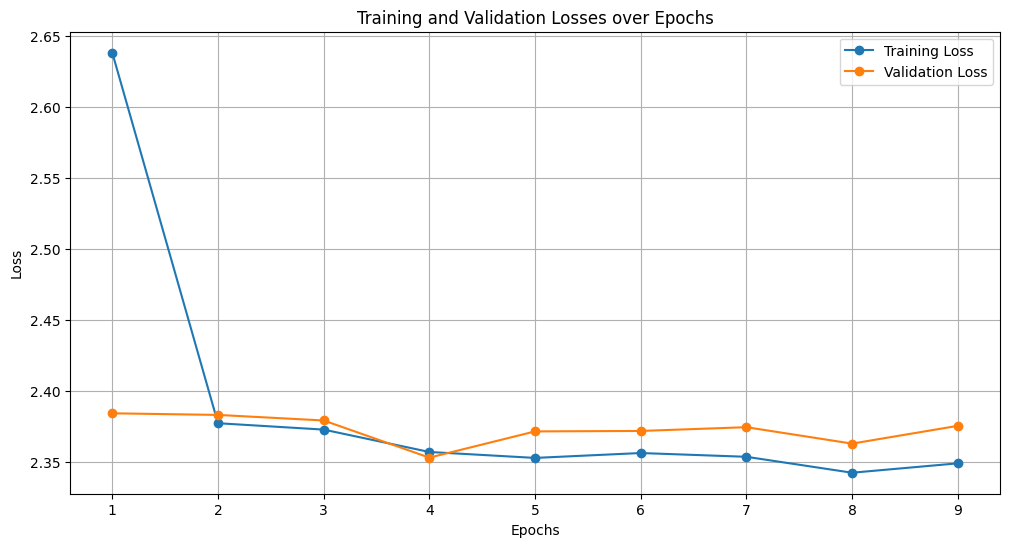

In [28]:
# Extract training history from Skorch neural net
train_losses = pipeline.named_steps["classifier"].history[:, 'train_loss']

valid_losses = pipeline.named_steps["classifier"].history[:, 'valid_loss']

epochs = np.arange(1, len(train_losses) + 1)

# Plot training and validation losses
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_losses, label='Training Loss', marker='o')
plt.plot(epochs, valid_losses, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses over Epochs')
plt.legend()
plt.grid(True)
plt.show()

***TESTING***

In [29]:
# Testing the initial model
y_pred = pipeline.predict(X_test)

test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

Test Accuracy: 95.33%


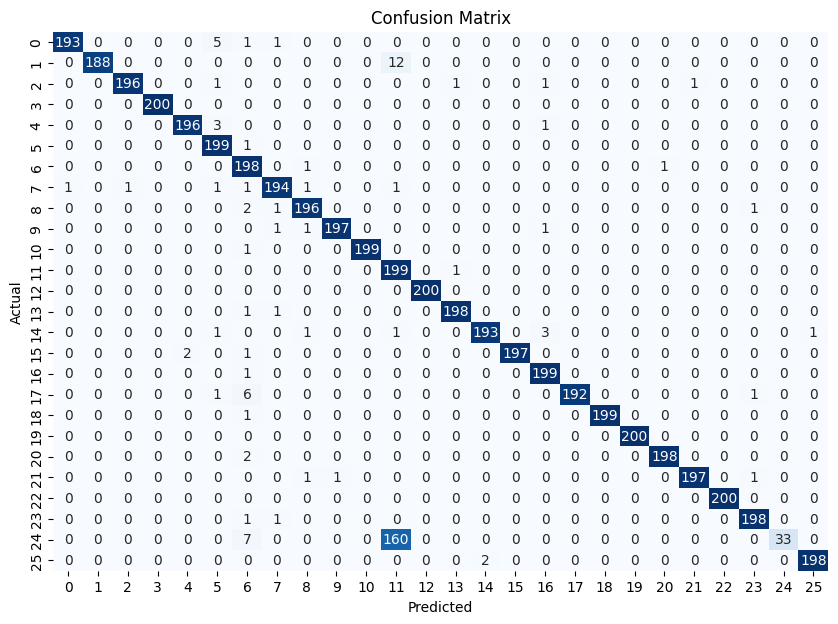

In [30]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot of the confusion matrix
plt.figure(figsize=(10, 7))

sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()